In [35]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import os
import pandas as pd
import random
import scipy.linalg
import seaborn as sns
import time

from tqdm.notebook import tqdm
from scipy.sparse.linalg.eigen.arpack import eigsh as largest_eigsh
from scipy import signal
from sklearn.cluster import KMeans



def pairwise_distances(X, Y):
    D = -2 * X @ Y.T + np.sum(Y ** 2, axis=1) + np.sum(X ** 2, axis=1)[:, np.newaxis]
    D[D < 0] = 0
    return D


def clustering(data, N_c):
    estimator = KMeans(init='random', n_clusters=N_c, n_init=3)
    estimator.fit(data)
    return estimator.cluster_centers_


seed = 1

system_name ='Rossler'
#         'Rabinovich Fabrikant',
#         'Lorenz'


random.seed(seed)
np.random.seed(seed)

U0 = np.loadtxt('dataset/' + system_name + '.csv', delimiter=',').T
U0 = np.atleast_2d(U0)
U = U0 + np.random.random(U0.shape)*1e-2

num_prepare = 1000
train_start = num_prepare
num_train = 10000
val_start = num_prepare + num_train
num_val = 100
test_start = num_prepare + num_train + num_val
num_test = 5000
print('dataset shape:', U.shape)

inSize = U.shape[0]
outSize = inSize
resSize = 1000
a = 1  # leaking rate
K = 0.99  # spectial radius
reg = 1e-6  # regularization coefficient
input_scaling = 1


# generation of random weights
input_scaling = np.max(U,axis=1)-np.min(U,axis=1)
Win = (np.random.rand(resSize, 1 + inSize) - 0.5) * np.hstack((1, input_scaling)).T
W = np.random.rand(resSize, resSize) - 0.5
# g = nx.erdos_renyi_graph(resSize, D / resSize, seed, True)
# W = nx.adjacency_matrix(g).todense()

largest_eigvals, _ = largest_eigsh(W @ W.T, 1, which='LM')
rhoW = np.sqrt(largest_eigvals[0])
W = W / rhoW * (K - 1 + a) / a
X = np.zeros((resSize, U.shape[1]))
x = np.zeros([resSize, 1])

for t in tqdm(range(U.shape[1])):
    u = U[:, t:t + 1]
    x = (1 - a) * x + a * np.tanh(Win @ np.vstack((1, u)) + W @ x)
    X[:, t:t + 1] = x


dataset shape: (3, 20000)


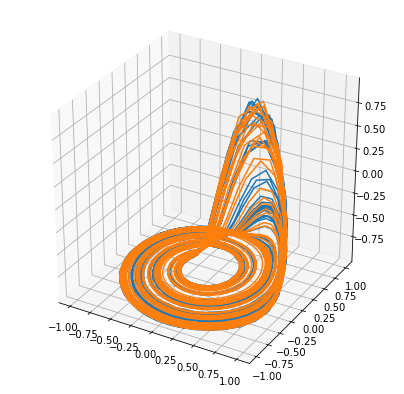

In [36]:

# offline train
U_train = U[:, train_start: train_start + num_train]
X_train = X[:, train_start: train_start + num_train]
Y_train = U[:, train_start + 1: train_start + num_train + 1]

H = np.vstack((np.ones((1, num_train)), X_train))
Wout = Y_train @ H.T @ np.linalg.inv(H @ H.T + reg * np.eye(H.shape[0]))
# print('pre_output shape:', H.shape)
# print('W_out shape:', Wout.shape)



horizon = 2000
Y_gen = np.zeros((U.shape[0], horizon))
for h in range(horizon):
    if h == 0:
        U_test = U[:, test_start: test_start + 1]
        X_test = X[:, test_start: test_start + 1]
    else:
        U_test = Y_pred
        X_test = (1 - a) * X_test + a * np.tanh(Win @ np.vstack((np.ones((1, 1)), U_test)) + W @ X_test)
    H = np.vstack((np.ones((1, 1)), X_test))
    Y_pred = Wout @ H
    # print(Y_gen[:, h] ,Y_pred)
    Y_gen[:, h:h+1] = Y_pred

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(*U[:3, :2000])
ax.plot(*Y_gen[:3, :2000])
plt.show()


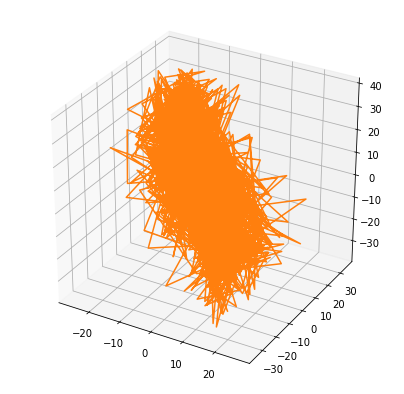

In [3]:

horizon = 2000
Y_gen = np.zeros((U.shape[0], horizon))
for h in range(horizon):
    if h == 0:
        U_test = U[:, test_start: test_start + 1]
        X_test =  np.zeros((resSize, 1))
#         X_test = X[:, test_start: test_start + 1]
    else:
        U_test = Y_pred
        X_test = (1 - a) * X_test + a * np.tanh(Win @ np.vstack((np.ones((1, 1)), U_test)) + W @ X_test)
    H = np.vstack((np.ones((1, 1)), X_test))
    Y_pred = Wout @ H
    # print(Y_gen[:, h] ,Y_pred)
    Y_gen[:, h:h+1] = Y_pred

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(*U[:3, :2000])
ax.plot(*Y_gen[:3, :2000])
plt.show()

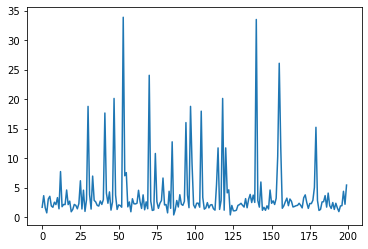

In [6]:
Ml, Diag, Mr = np.linalg.svd(X_train, full_matrices=False)

N_v = 10
Ml, Diag, Mr = Ml[:,:N_v], Diag[:N_v], Mr[:N_v]

# Cs = (np.diag(Diag) @ Mr).T[np.random.choice(num_train, N_c,replace=False)]

N_c = 200
Cs = clustering((np.diag(Diag) @ Mr).T, N_c)  # N_c, N_v

# okm = OnlineKMeans(N_v, N_c, flag=True, random_init=False)
# for p in tqdm((Ml.T @ X_train).T):
#     okm.fit(p)

# Cs = okm.centroid
# sigmas = okm.centroid_dist2neighbor
sigmas = np.min(pairwise_distances(Cs, Cs) + np.eye(N_c)*100, axis=0)
plt.plot(sigmas)

In [7]:
def col_normalize(x, f=None):
    if x.shape[0] == 0:
        return x

    fx = f(x) if f else x
    fx_sum = fx.sum(axis=0).reshape([1, fx.shape[1]])
    return fx / fx_sum


S = np.exp(- pairwise_distances(Cs, (np.diag(Diag) @ Mr).T)/
            (2 * sigmas.reshape((-1, 1))))
# S = np.exp(- pairwise_distances(Cs, (np.diag(Diag) @ Mr).T))
# S = col_normalize(S, np.exp)
S_trans = S[:,1:] @ S[:,:-1].T @ np.linalg.inv(S[:,:-1] @ S[:,:-1].T + reg * np.eye(N_c))

In [28]:

# plt.figure(figsize=(10,10))
# sns.heatmap(S[:,:1000])
# plt.show()

# plt.figure(figsize=(10,10))
# sns.heatmap(S_trans)
# plt.show()

# plt.plot(np.sum(S, axis=0))
Cs.shape # 200, 10
(Ml.T @X).shape # 10, 20000

S1 = (Cs[:,None] - (Ml.T @X).T).T @ S 

In [30]:
# threshold = np.percentile(np.sum(S, axis=0), 99)
print(S1.shape)

H = np.vstack((np.ones((1, num_train)), X_train, S1))
Wout1 = Y_train @ H.T @ np.linalg.inv(H @ H.T + reg * np.eye(H.shape[0]))
#

(10, 20000, 10000)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 2 has 3 dimension(s)

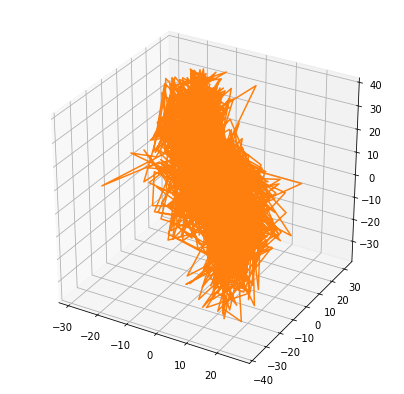

In [223]:
horizon = 2000
Y_gen = np.zeros((U.shape[0], horizon))
k = 4
for h in tqdm(range(horizon)):
    if h == 0:
        U_test = U[:, test_start: test_start + 1]
        X_test =  X[:, test_start: test_start + 1]+0.01

    else:
        U_test = Y_pred
        X_test = (1 - a) * X_test + a * np.tanh(Win @ np.vstack((np.ones((1, 1)), U_test)) + W @ X_test)
        D = pairwise_distances(Cs, (Ml.T @ X_test).T)
        nearest_indice = np.argpartition(D.flatten(), k)[:k]
        nearestX = np.zeros((resSize, 3*k))
        i = 0
        for idx in nearest_indice:
            xi = Ml @ Cs[idx:idx+1].T
            for i in range(3):
                nearestX[:,i:i+1] = xi
                i += 1
                yi = Wout @ np.vstack((np.ones((1, 1)), xi))
                xi = (1 - a) * xi + a * np.tanh(Win @ np.vstack((np.ones((1, 1)), yi)) + W @ xi)
   
        D = pairwise_distances(nearestX.T, (X_test).T)
        D -= np.min(D)
        nearest_indice = np.argpartition(D.flatten(), k)[:k]
        X_test = 0.99*X_test + 0.01* nearestX[:,nearest_indice] @ col_normalize(-D[nearest_indice], np.exp)



    H = np.vstack((np.ones((1, 1)), X_test))
    Y_pred = Wout @ H
    Y_gen[:, h:h+1] = Y_pred

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(*U[:3, :2000])
ax.plot(*Y_gen[:3, :2000])
plt.show()


In [172]:
np.argpartition([1,2,3,4,5],3)

array([1, 0, 2, 3, 4], dtype=int64)

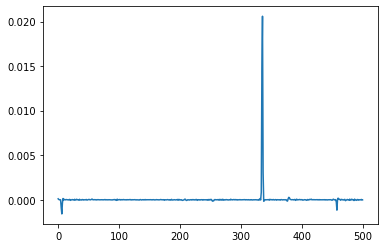

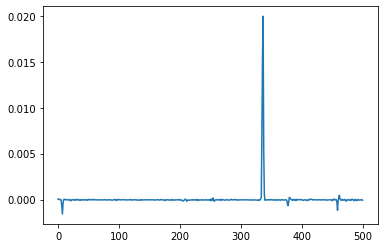

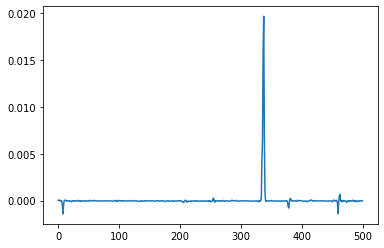

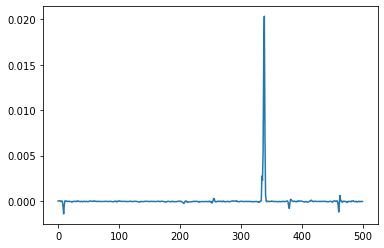

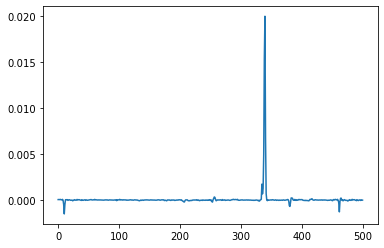

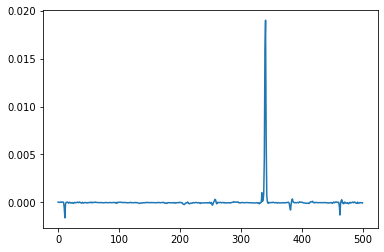

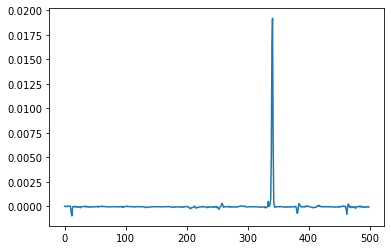

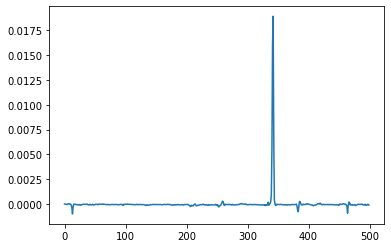

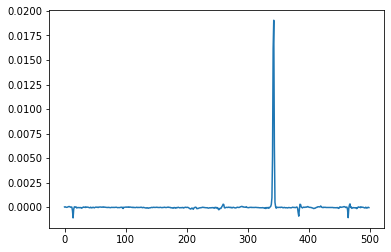

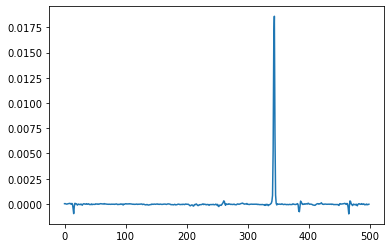

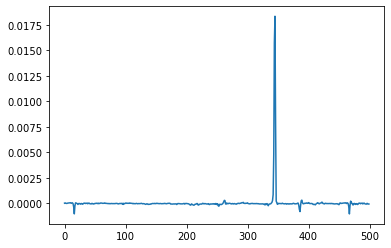

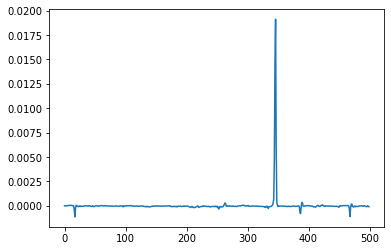

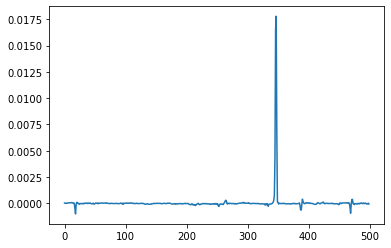

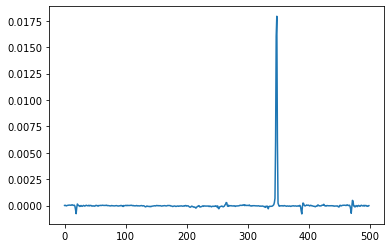

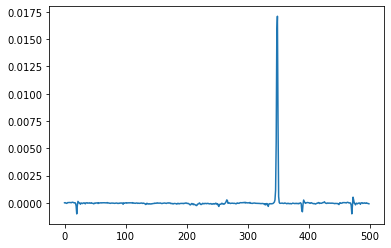

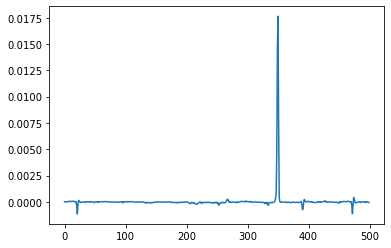

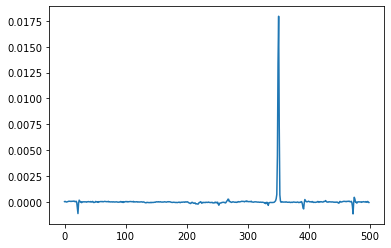

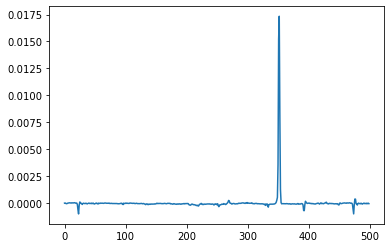

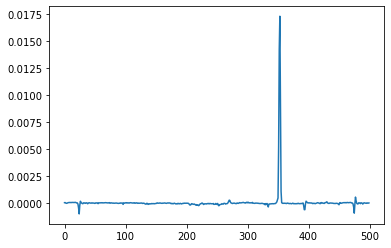

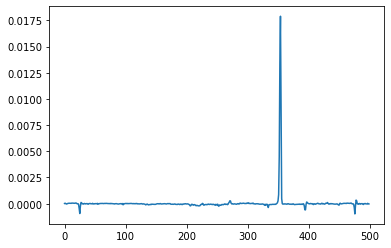

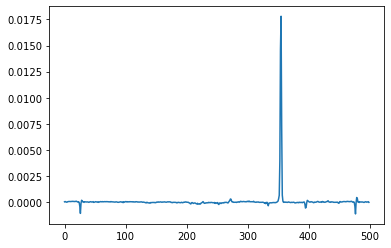

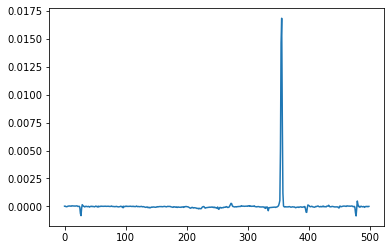

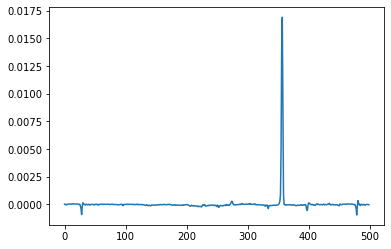

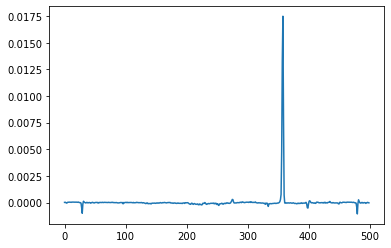

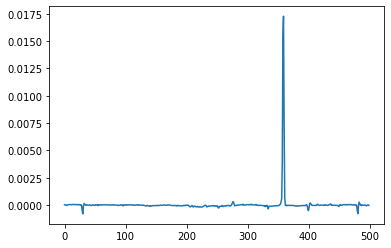

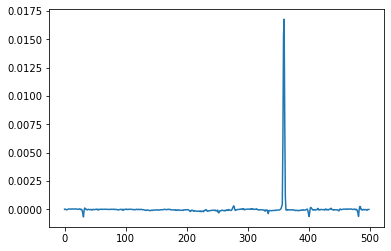

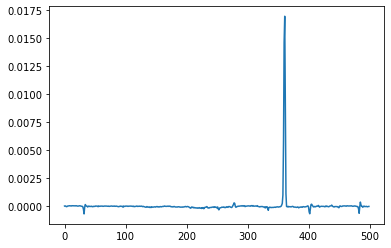

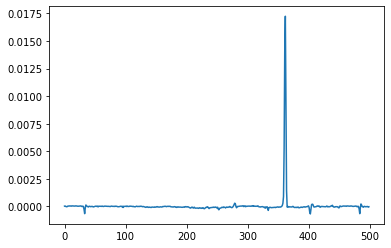

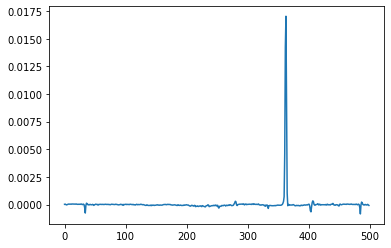

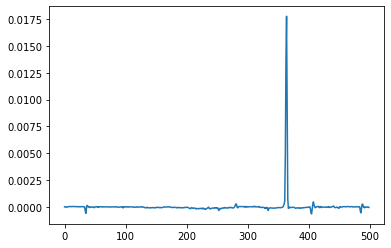

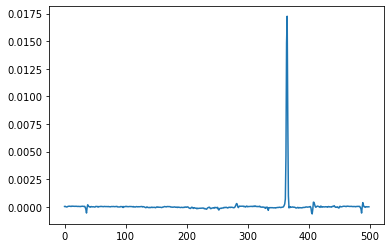

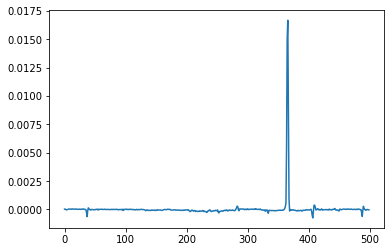

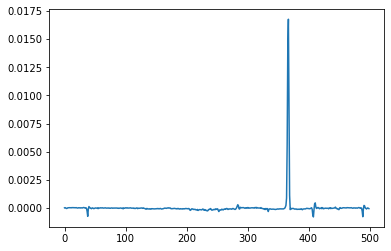

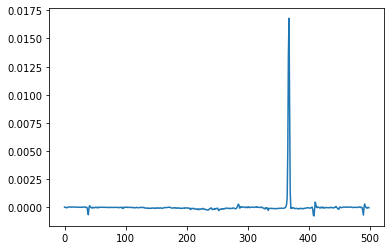

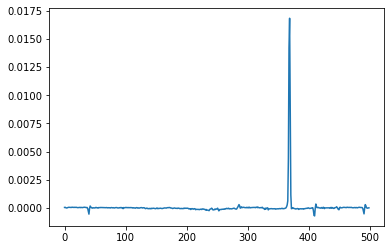

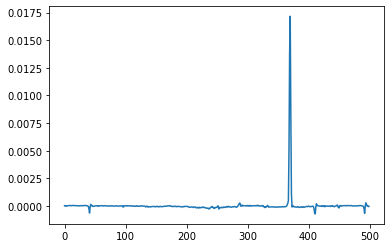

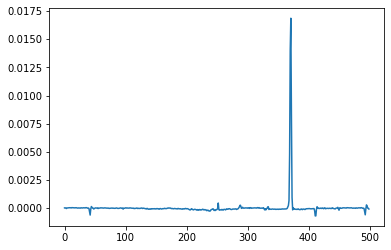

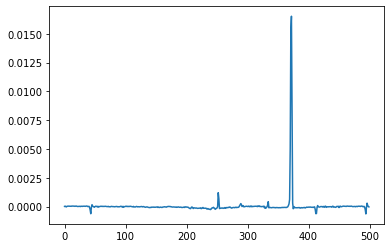

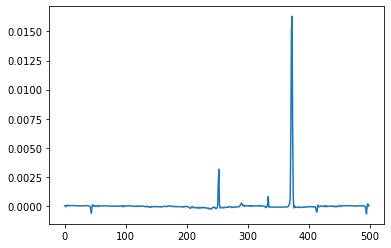

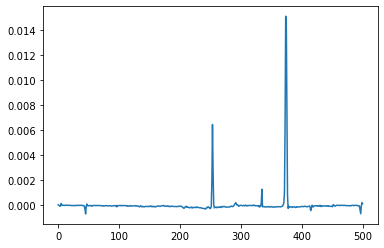

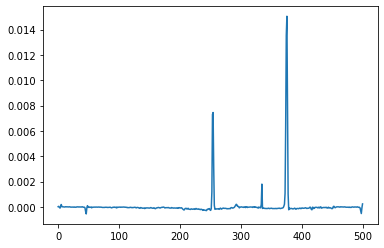

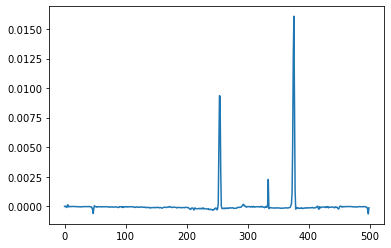

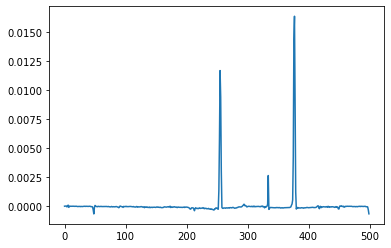

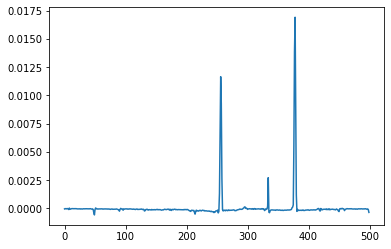

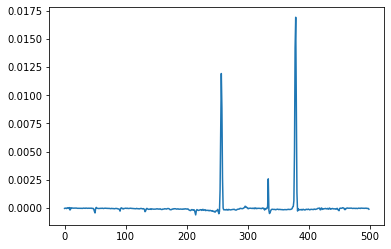

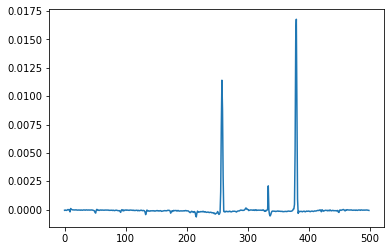

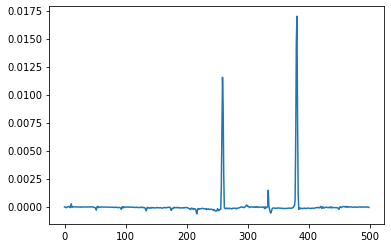

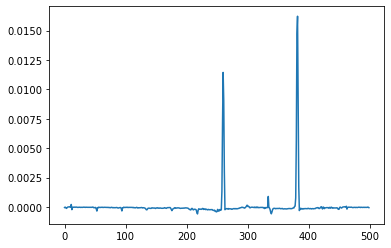

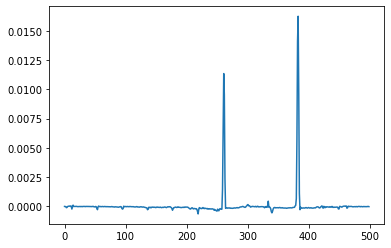

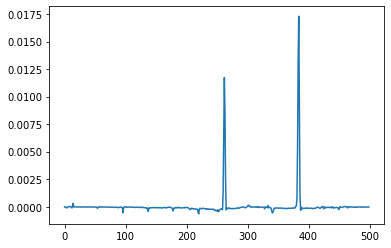

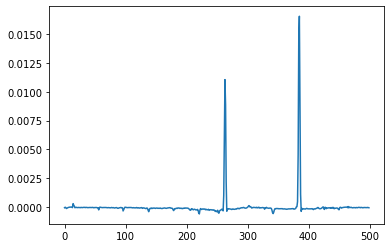

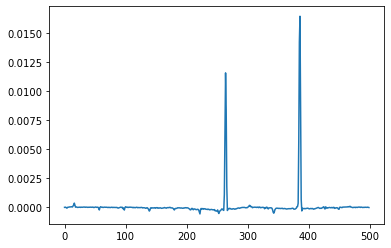

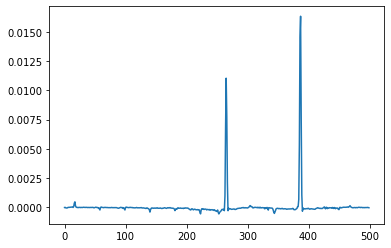

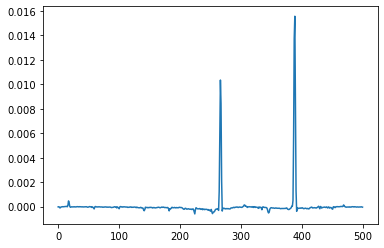

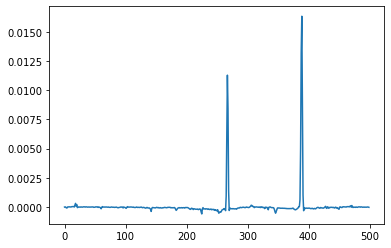

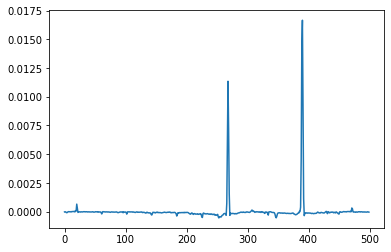

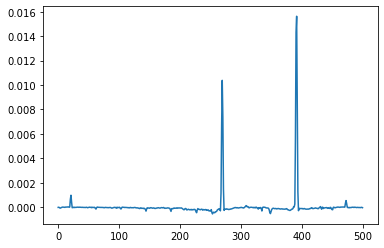

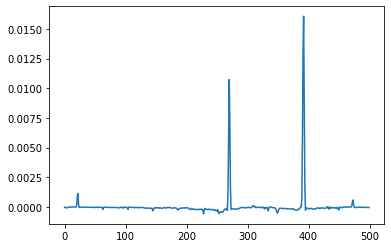

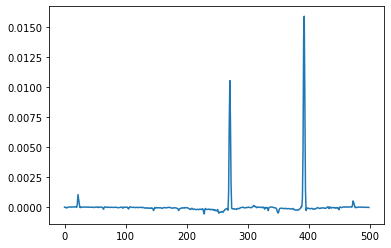

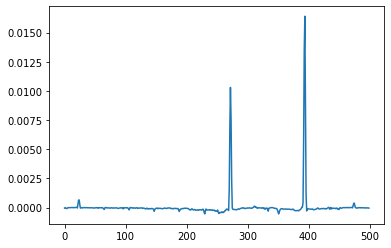

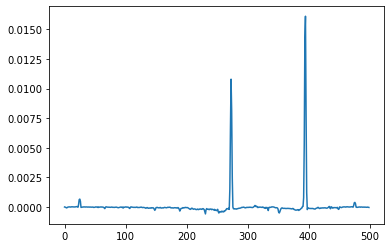

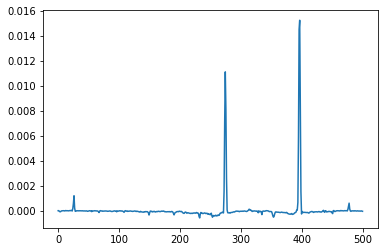

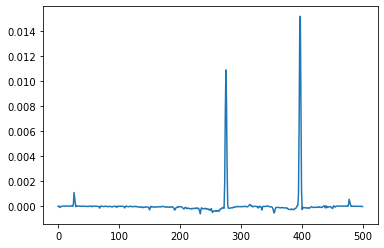

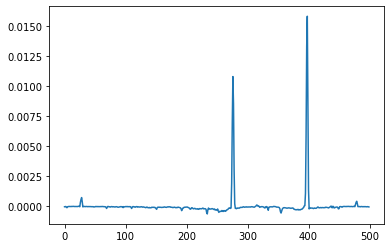

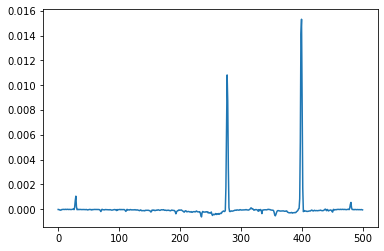

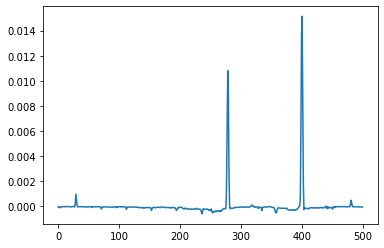

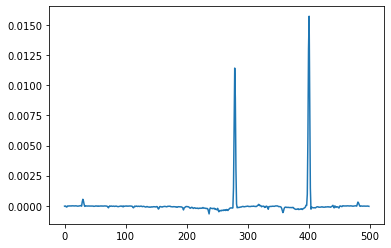

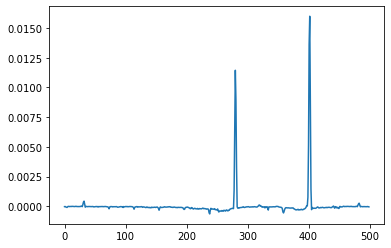

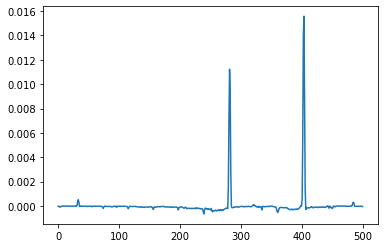

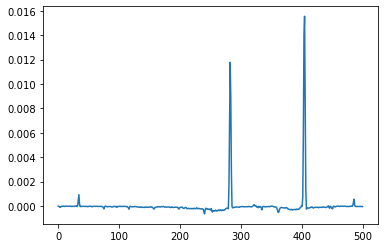

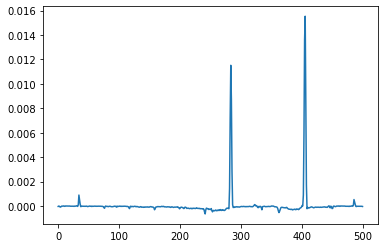

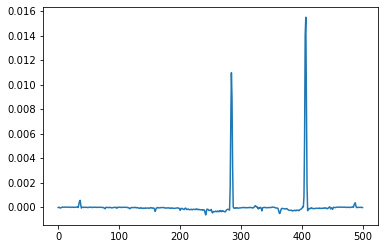

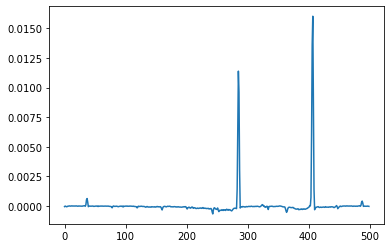

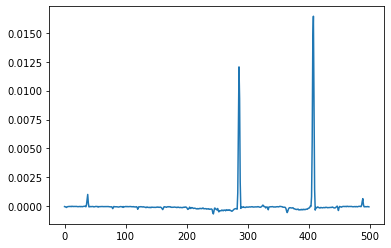

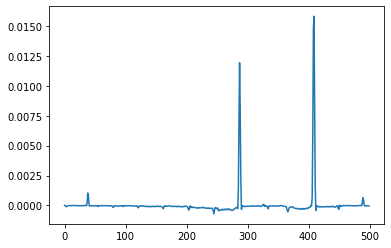

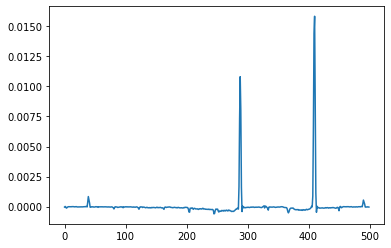

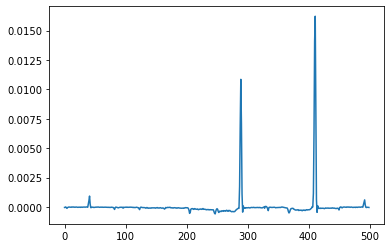

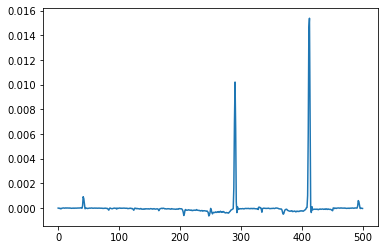

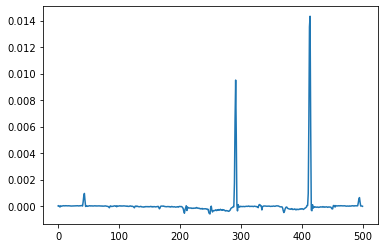

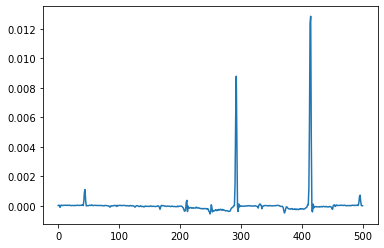

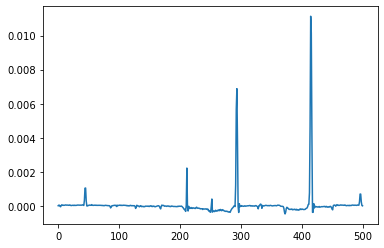

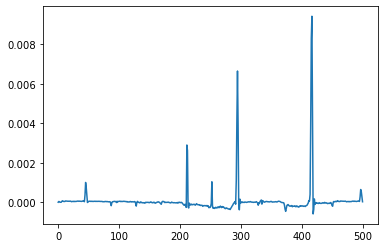

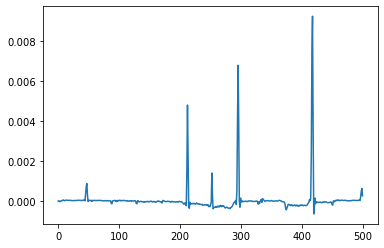

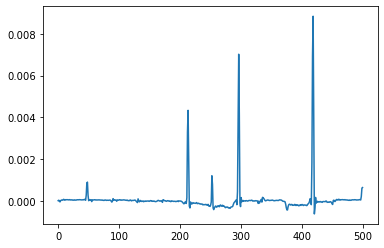

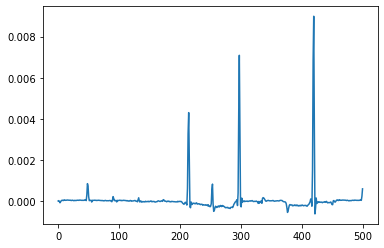

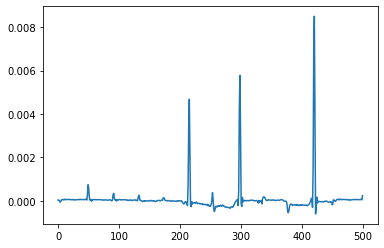

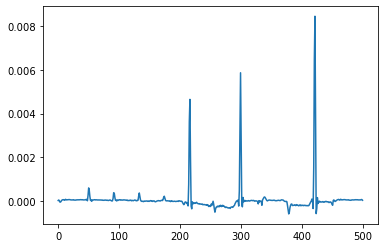

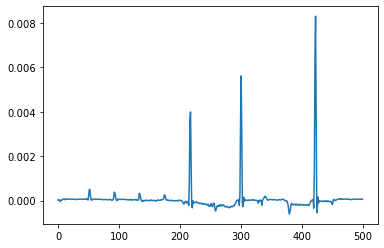

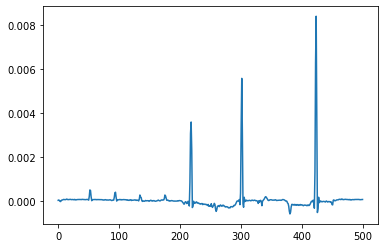

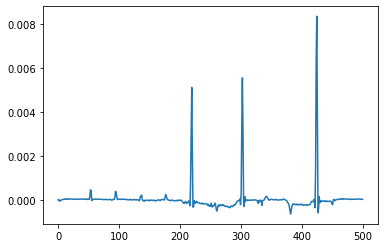

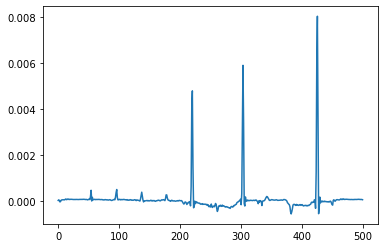

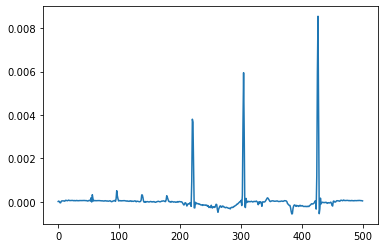

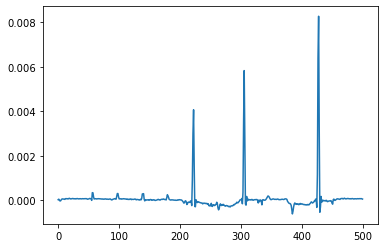

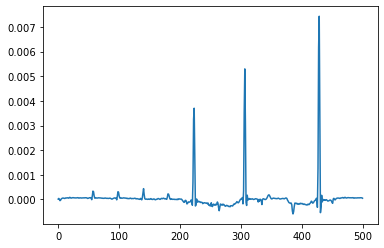

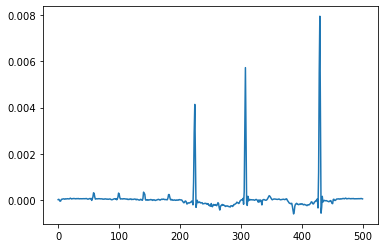

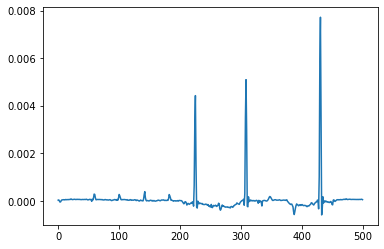

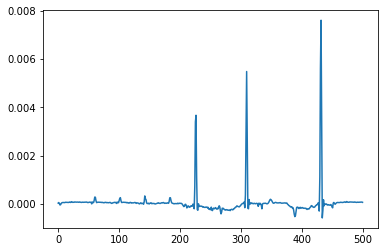

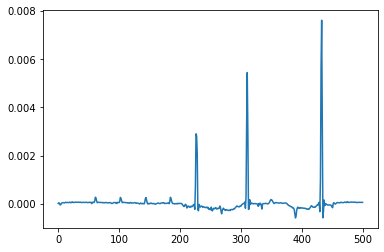

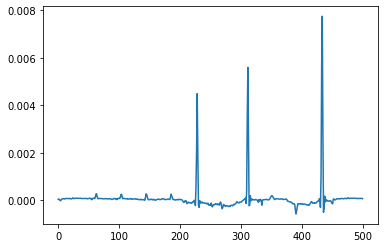

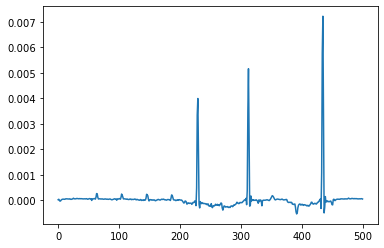

In [82]:
for i in range(100):
    S = S_trans @S 
    plt.plot(S)
    plt.show()

In [13]:
class OnlineKMeans:
    """ Online K Means Algorithm """

    def __init__(self,
                 num_features: int,
                 num_clusters: int,
                 lr=None,
                 flag=True,
                 random_init=False
                 ):
        """
        :param num_features: The dimension of the data
        :param num_clusters: The number of clusters to form as well as the number of centroids to generate.
        :param lr: The learning rate of the online k-means (c', t0). If None, then we will use the simplest update
        rule (c'=1, t0=0) as described in the lecture.
        """
        if num_features < 1:
            raise ValueError(f"num_features must be greater or equal to 1!\nGet {num_features}")
        if num_clusters < 1:
            raise ValueError(f"num_clusters must be greater or equal to 1!\nGet {num_clusters}")

        self.num_features = num_features
        self.num_clusters = num_clusters

        self.num_centroids = 0
        self.centroid = np.random.random((num_clusters, num_features)) if random_init else np.zeros(
            (num_clusters, num_features))
        self.cluster_counter = np.zeros(num_clusters)  # Count how many points have been assigned into this cluster
        self.centroid_D = np.zeros((num_clusters, num_clusters))
        self.centroid_dist2neighbor = np.zeros((num_clusters, 1))

        self.num_samples = 0
        self.lr = lr
        self.flag = flag
        self.random_init = random_init

    def fit(self, X):
        """
        Receive a sample (or mini batch of samples) online, and update the centroids of the clusters
        :param X: (num_features,) or (num_samples, num_features)
        :return:
        """
        if len(X.shape) == 1:
            X = X[np.newaxis, :]
        num_samples, num_features = X.shape

        for i in range(num_samples):
            self.num_samples += 1
            # Did not find enough samples, directly set it to mean
            if not self.random_init and self.num_centroids < self.num_clusters:
                self.centroid[self.num_centroids] = X[i]
                self.cluster_counter[self.num_centroids] += 1
                self.num_centroids += 1
            else:
                # Determine the closest centroid for this sample
                sample = X[i]
                dist = np.linalg.norm(self.centroid - sample, axis=1)

                if self.flag:
                    self.centroid_D = pairwise_distances(self.centroid, self.centroid) + 100 * np.eye(
                        self.num_clusters)
                    self.centroid_dist2neighbor = np.min(self.centroid_D, axis=1)
                    if np.min(dist) > np.average(self.centroid_dist2neighbor) + np.std(self.centroid_dist2neighbor):
                        to_delete = np.argmin(self.centroid_dist2neighbor)
                        self.centroid[to_delete] = sample
                        self.cluster_counter[to_delete] = 0
                else:
                    centroid_idx = np.argmin(dist)

                    if self.lr is None:
                        self.centroid[centroid_idx] = (self.cluster_counter[centroid_idx] * self.centroid[
                            centroid_idx] + sample) / (self.cluster_counter[centroid_idx] + 1)
                        self.cluster_counter[centroid_idx] += 1
                    else:
                        #                     c_prime, t0 = self.lr
                        #                     rate = c_prime / (t0 + self.num_samples)
                        rate = self.lr
                        self.centroid[centroid_idx] = (1 - rate) * self.centroid[centroid_idx] + rate * sample
                        self.cluster_counter[centroid_idx] += 1

    def predict(self, X):
        """
        Predict the cluster labels for each sample in X
        :param X: (num_features,) or (num_samples, num_features)
        :return: Returned index starts from zero
        """
        if len(X.shape) == 1:
            X = X[np.newaxis, :]
        num_samples, num_features = X.shape

        clusters = np.zeros(num_samples)
        for i in range(num_samples):
            sample = X[i]
            dist = np.linalg.norm(self.centroid - sample, axis=1)
            clusters[i] = np.argmin(dist)
        return clusters

    def fit_predict(self, X):
        """
        Compute cluster centers and predict cluster index for each sample.
        :param X: (num_features,) or (num_samples, num_features)
        :return:
        """
        # Because the centroid may change in the online setting, we cannot determine the cluster of each label until
        # we finish fitting.
        self.fit(X)
        return self.predict(X)
